In [1]:
!pip install -q kaggle


In [2]:
import json, os

KAGGLE_USERNAME = "akshitharr"   # replace
KAGGLE_KEY      = "KGAT_43589fd5413c70ebdde5be48d358cc79"  # replace with your key

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)

!chmod 600 /root/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d emmarex/plantdisease -q

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown


In [5]:
!unzip -q plantdisease.zip -d /content/plantdisease

unzip:  cannot find or open plantdisease.zip, plantdisease.zip.zip or plantdisease.zip.ZIP.


In [12]:
# UNZIP THE DATASET AGAIN
!unzip -q "/content/plantdisease.zip" -d "/content/plantdisease"

# Confirm extraction
import os
print("Inside /content/plantdisease:", os.listdir("/content/plantdisease"))

Inside /content/plantdisease: ['PlantVillage', 'plantvillage']


In [13]:
DATA_DIR = "/content/plantdisease/PlantVillage"

In [14]:
print("Using DATA_DIR =", DATA_DIR)
print("Classes:", os.listdir(DATA_DIR))

Using DATA_DIR = /content/plantdisease/PlantVillage
Classes: ['Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Late_blight', 'Potato___healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Pepper__bell___Bacterial_spot', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Potato___Early_blight']


In [35]:
# Cell 1
# (If TF already installed, this just imports)
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
print("TF", tf.__version__)
# set seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

TF 2.19.0


In [36]:
# Cell 2
DATA_DIR = "/content/plantdisease/PlantVillage"
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
classes = sorted(os.listdir(DATA_DIR))
print("Classes:", classes)
NUM_CLASSES = len(classes)
IMG_SIZE = 224   # better detail for pretrained models
BATCH = 32

DATA_DIR exists: True
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [37]:
# Cell 3 - build dataframe of filepath + label to use with generators
import pandas as pd
filepaths = []
labels = []
for idx, cls in enumerate(classes):
    folder = os.path.join(DATA_DIR, cls)
    for fname in os.listdir(folder):
        filepaths.append(os.path.join(folder, fname))
        labels.append(cls)

df = pd.DataFrame({"filepath": filepaths, "label": labels})
print("Total images:", len(df))
df.head()

Total images: 20639


,filepath,label
0,/content/plantdisease/PlantVillage/Pepper__bel...,Pepper__bell___Bacterial_spot
1,/content/plantdisease/PlantVillage/Pepper__bel...,Pepper__bell___Bacterial_spot
2,/content/plantdisease/PlantVillage/Pepper__bel...,Pepper__bell___Bacterial_spot
3,/content/plantdisease/PlantVillage/Pepper__bel...,Pepper__bell___Bacterial_spot
4,/content/plantdisease/PlantVillage/Pepper__bel...,Pepper__bell___Bacterial_spot


In [38]:
# Cell 4
train_df, test_df = train_test_split(df, test_size=0.30, random_state=SEED, stratify=df['label'])
print("Train:", len(train_df), " Test:", len(test_df))
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Train: 14447  Test: 6192


In [39]:
# Cell 5
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    shear_range=0.05,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH, class_mode='categorical', shuffle=True, seed=SEED
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH, class_mode='categorical', shuffle=False
)

class_indices = train_gen.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}
print("Num classes:", NUM_CLASSES)
print("Class indices example:", list(class_indices.items())[:6])

Found 14446 validated image filenames belonging to 15 classes.
Found 6192 validated image filenames belonging to 15 classes.
Num classes: 15
Class indices example: [('Pepper__bell___Bacterial_spot', 0), ('Pepper__bell___healthy', 1), ('Potato___Early_blight', 2), ('Potato___Late_blight', 3), ('Potato___healthy', 4), ('Tomato_Bacterial_spot', 5)]


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [40]:
# Cell 6
# compute weights using training labels (integers)
y_train_integers = train_gen.classes  # integer class indices per sample in train generator
cw = compute_class_weight('balanced', classes=np.unique(y_train_integers), y=y_train_integers)
class_weights = {i: cw[i] for i in range(len(cw))}
print("Class weights sample:", list(class_weights.items())[:6])

Class weights sample: [(0, np.float64(1.3797516714422158)), (1, np.float64(0.9304991948470209)), (2, np.float64(1.3758095238095238)), (3, np.float64(1.3758095238095238)), (4, np.float64(9.08553459119497)), (5, np.float64(0.646787553167674))]


In [41]:
# Cell 7
base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base.trainable = False   # freeze base for initial training

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
# Cell 8
EPOCHS_1 = 6   # initial quick stage
history1 = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS_1,
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
452/452 ━━━━━━━━━━━━━━━━━━━━ 230s 469ms/step - accuracy: 0.3311 - loss: 2.1436 - val_accuracy: 0.7511 - val_loss: 0.9250
Epoch 2/6
452/452 ━━━━━━━━━━━━━━━━━━━━ 179s 396ms/step - accuracy: 0.6850 - loss: 0.9839 - val_accuracy: 0.8073 - val_loss: 0.6504
Epoch 3/6
452/452 ━━━━━━━━━━━━━━━━━━━━ 177s 391ms/step - accuracy: 0.7539 - loss: 0.7387 - val_accuracy: 0.8361 - val_loss: 0.5416
Epoch 4/6
452/452 ━━━━━━━━━━━━━━━━━━━━ 180s 398ms/step - accuracy: 0.7875 - loss: 0.6233 - val_accuracy: 0.8532 - val_loss: 0.4829
Epoch 5/6
452/452 ━━━━━━━━━━━━━━━━━━━━ 180s 398ms/step - accuracy: 0.8170 - loss: 0.5457 - val_accuracy: 0.8640 - val_loss: 0.4505
Epoch 6/6
452/452 ━━━━━━━━━━━━━━━━━━━━ 177s 392ms/step - accuracy: 0.8324 - loss: 0.4907 - val_accuracy: 0.8493 - val_loss: 0.4627


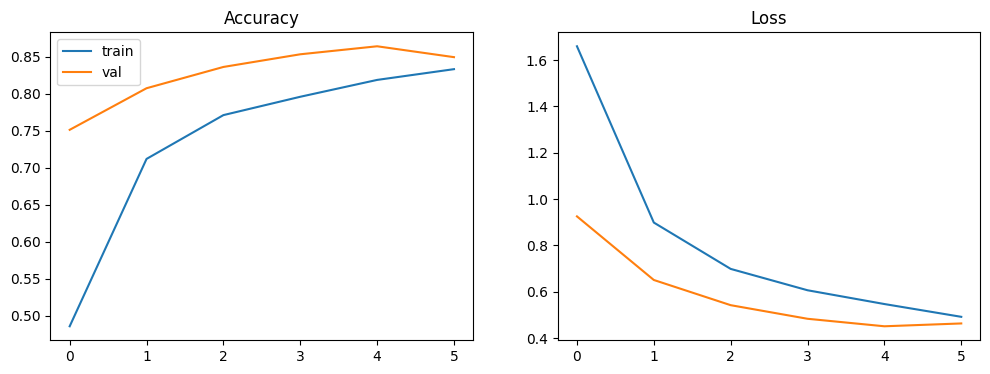

In [44]:
# Cell 10
def plot_history(hists):
    plt.figure(figsize=(12,4))
    # accuracy
    plt.subplot(1,2,1)
    for h in hists:
        plt.plot(h.history['accuracy'])
    for h in hists:
        plt.plot(h.history['val_accuracy'])
    plt.title("Accuracy")
    plt.legend(['train']*len(hists)+['val']*len(hists))
    # loss
    plt.subplot(1,2,2)
    for h in hists:
        plt.plot(h.history['loss'])
    for h in hists:
        plt.plot(h.history['val_loss'])
    plt.title("Loss")
    plt.show()

# call it with one or two histories
plot_history([history1] + ([history2] if 'history2' in globals() else []))

194/194 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step
Test accuracy: 0.8611111111111112

Classification report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.93      0.94       299
                     Pepper__bell___healthy       0.95      0.98      0.97       443
                      Potato___Early_blight       0.98      0.95      0.96       300
                       Potato___Late_blight       0.90      0.87      0.88       300
                           Potato___healthy       0.69      1.00      0.81        46
                      Tomato_Bacterial_spot       0.84      0.97      0.90       638
                        Tomato_Early_blight       0.77      0.54      0.64       300
                         Tomato_Late_blight       0.95      0.75      0.84       573
                           Tomato_Leaf_Mold       0.52      0.95      0.67       286
                  Tomato_Septoria_leaf_spot    

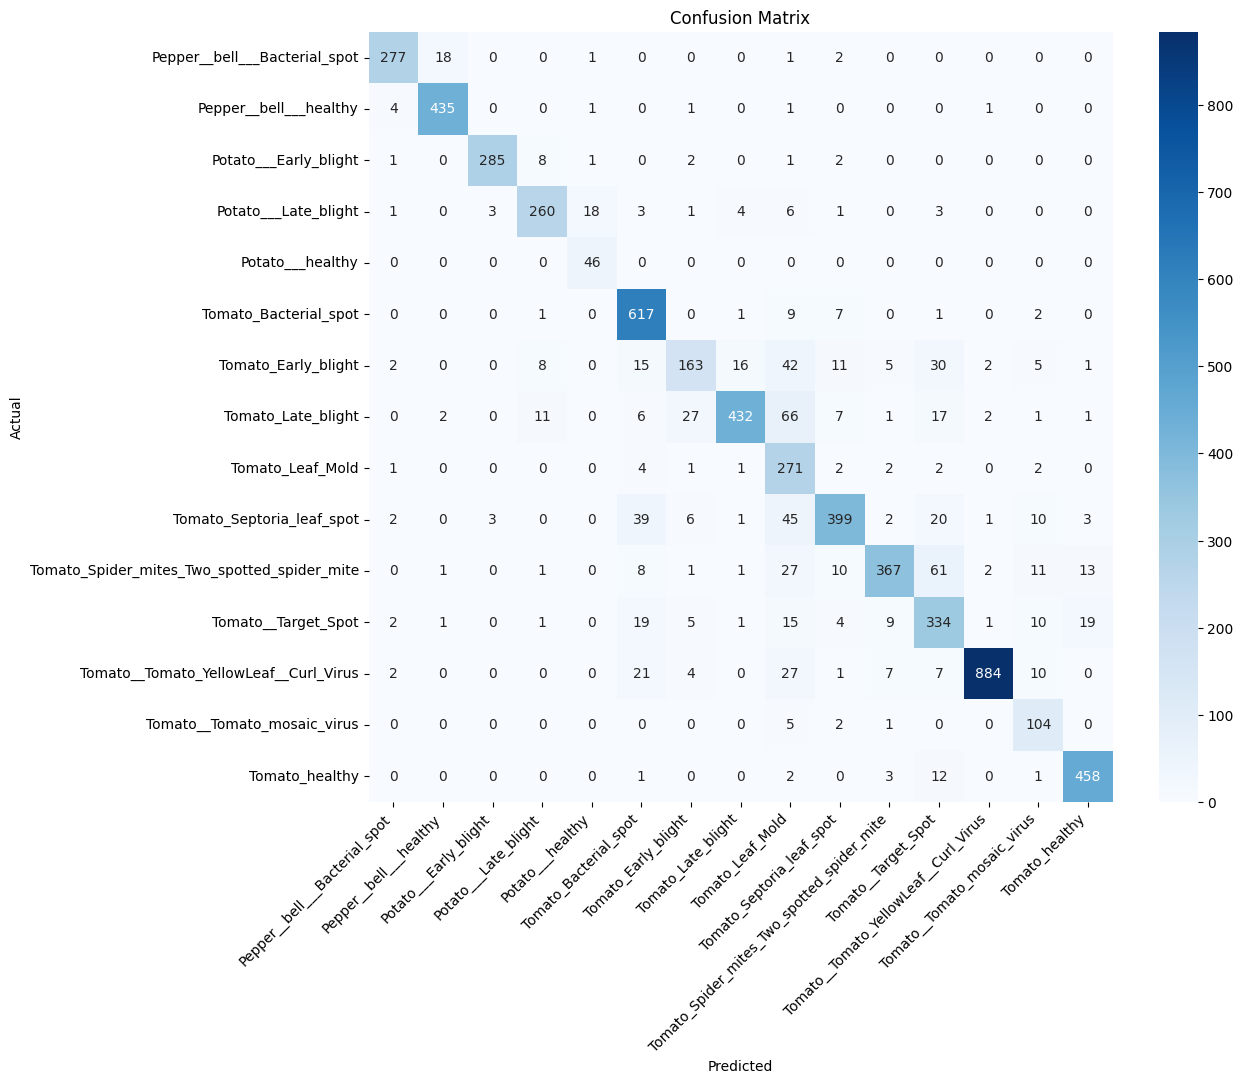

In [45]:
# Cell 11
import numpy as np
test_gen.reset()
y_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

acc = accuracy_score(y_true, y_pred)
print("Test accuracy:", acc)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys()), zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_indices.keys()), yticklabels=list(class_indices.keys()))
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

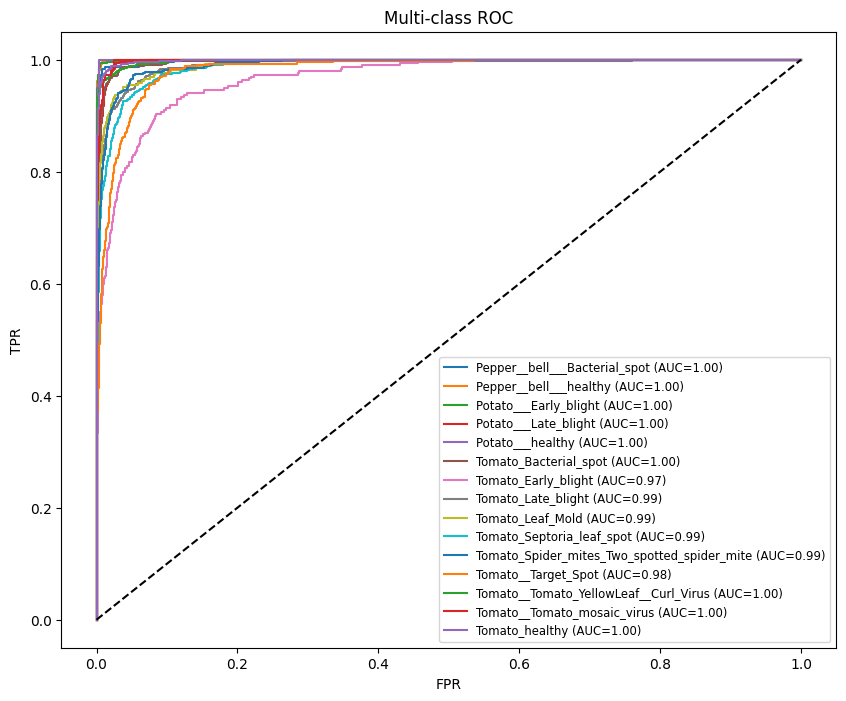

In [46]:
# Cell 12
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
plt.figure(figsize=(10,8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_prob[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{inv_class_indices[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.legend(loc='lower right', fontsize='small')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Multi-class ROC')
plt.show()

File: /content/plantdisease/PlantVillage/Tomato_Bacterial_spot/e28b2c59-c08e-4957-975f-2965d8b801e2___GCREC_Bact.Sp 3321.JPG
Actual: Tomato_Bacterial_spot
Predicted: Tomato_Bacterial_spot (0.979)


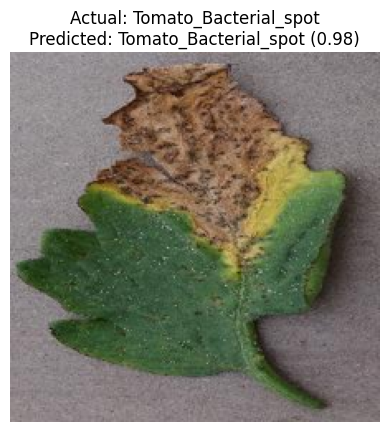

In [47]:
# Cell 13
test_index = 122   # change to any index in 0..len(test_df)-1
if test_index < 0 or test_index >= len(test_df):
    print("Index out of range:", len(test_df))
else:
    # show filepath, actual, prediction
    fp = test_df.loc[test_index, 'filepath']
    actual = test_df.loc[test_index, 'label']
    pred_label = inv_class_indices[y_pred[test_index]]
    prob = y_prob[test_index][y_pred[test_index]]
    print("File:", fp)
    print("Actual:", actual)
    print("Predicted:", pred_label, f"({prob:.3f})")
    from PIL import Image
    img = Image.open(fp).resize((IMG_SIZE,IMG_SIZE))
    plt.imshow(img); plt.axis('off'); plt.title(f"Actual: {actual}\nPredicted: {pred_label} ({prob:.2f})"); plt.show()

File: /content/plantdisease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/d6540905-ccfd-4b5e-b08d-0dadf7b28215___Com.G_SpM_FL 1280.JPG
Actual: Tomato_Spider_mites_Two_spotted_spider_mite
Predicted: Tomato_Spider_mites_Two_spotted_spider_mite (0.502)


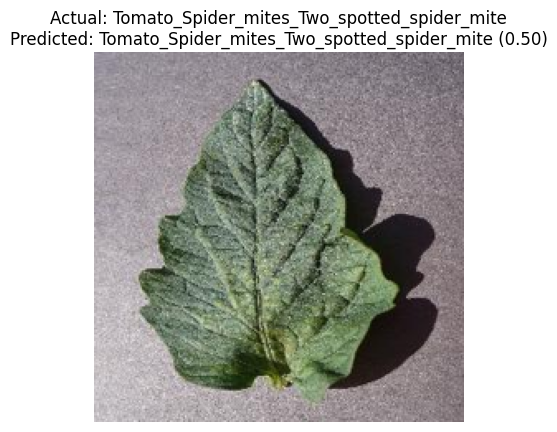

In [48]:
# Cell 13
test_index = 304   # change to any index in 0..len(test_df)-1
if test_index < 0 or test_index >= len(test_df):
    print("Index out of range:", len(test_df))
else:
    # show filepath, actual, prediction
    fp = test_df.loc[test_index, 'filepath']
    actual = test_df.loc[test_index, 'label']
    pred_label = inv_class_indices[y_pred[test_index]]
    prob = y_prob[test_index][y_pred[test_index]]
    print("File:", fp)
    print("Actual:", actual)
    print("Predicted:", pred_label, f"({prob:.3f})")
    from PIL import Image
    img = Image.open(fp).resize((IMG_SIZE,IMG_SIZE))
    plt.imshow(img); plt.axis('off'); plt.title(f"Actual: {actual}\nPredicted: {pred_label} ({prob:.2f})"); plt.show()

Saving plant_5.jpg to plant_5 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
plant_5 (1).jpg -> Pepper__bell___Bacterial_spot (0.704)


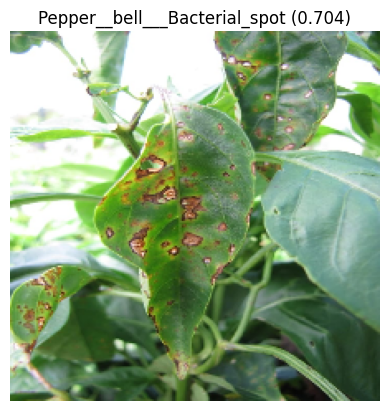

In [49]:
# Cell 14 - upload files and predict
from google.colab import files
uploaded = files.upload()
for fname in uploaded.keys():
    path = fname
    img = tf.keras.preprocessing.image.load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
    arr = tf.keras.preprocessing.image.img_to_array(img)/255.0
    arr = np.expand_dims(arr,0)
    p = model.predict(arr)[0]
    idx = np.argmax(p)
    print(fname, "->", inv_class_indices[idx], f"({p[idx]:.3f})")
    plt.imshow(img); plt.title(f"{inv_class_indices[idx]} ({p[idx]:.3f})"); plt.axis('off'); plt.show()

Saving plant_3.jpg to plant_3 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
plant_3 (1).jpg -> Tomato_Early_blight (0.706)


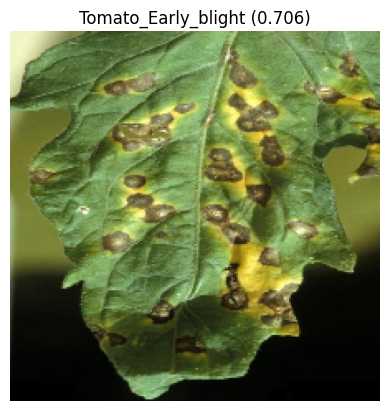

In [50]:
# Cell 14 - upload files and predict
from google.colab import files
uploaded = files.upload()
for fname in uploaded.keys():
    path = fname
    img = tf.keras.preprocessing.image.load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
    arr = tf.keras.preprocessing.image.img_to_array(img)/255.0
    arr = np.expand_dims(arr,0)
    p = model.predict(arr)[0]
    idx = np.argmax(p)
    print(fname, "->", inv_class_indices[idx], f"({p[idx]:.3f})")
    plt.imshow(img); plt.title(f"{inv_class_indices[idx]} ({p[idx]:.3f})"); plt.axis('off'); plt.show()

Saving plant_2.jpg to plant_2 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
plant_2 (1).jpg -> Tomato_Late_blight (0.613)


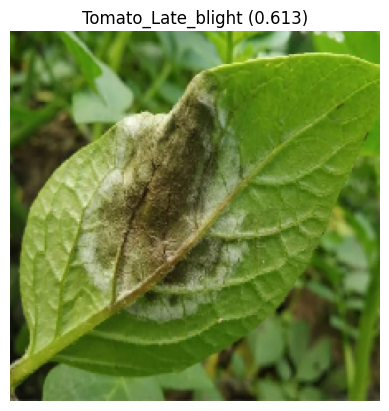

In [51]:
# Cell 14 - upload files and predict
from google.colab import files
uploaded = files.upload()
for fname in uploaded.keys():
    path = fname
    img = tf.keras.preprocessing.image.load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
    arr = tf.keras.preprocessing.image.img_to_array(img)/255.0
    arr = np.expand_dims(arr,0)
    p = model.predict(arr)[0]
    idx = np.argmax(p)
    print(fname, "->", inv_class_indices[idx], f"({p[idx]:.3f})")
    plt.imshow(img); plt.title(f"{inv_class_indices[idx]} ({p[idx]:.3f})"); plt.axis('off'); plt.show()

In [53]:
# Save the trained model
model.save("plant_disease_model.h5")

print("Model saved successfully!")

Model saved successfully!


In [54]:
from google.colab import files

files.download("plant_disease_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
from google.colab import files
files.download("plant_disease_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>